In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from tensorflow import keras

In [52]:
data_dir = pathlib.Path('./Dataset/')
image_count = len(list(data_dir.glob('*/*.jpeg')))
print('Hay un total de '+str(image_count)+' imagenes')

epitrix = list(data_dir.glob('epitrix/*'))
sano = list(data_dir.glob('sano/*'))
tizon = list(data_dir.glob('tizon/*'))

batch_size = 128
img_hei=224
img_wid=224

Hay un total de 59 imagenes


In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_hei, img_wid),
    batch_size = batch_size
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_hei, img_wid),
    batch_size= batch_size
)

Found 659 files belonging to 3 classes.
Using 528 files for training.
Found 659 files belonging to 3 classes.
Using 131 files for validation.


['epitrix', 'sano', 'tizon']


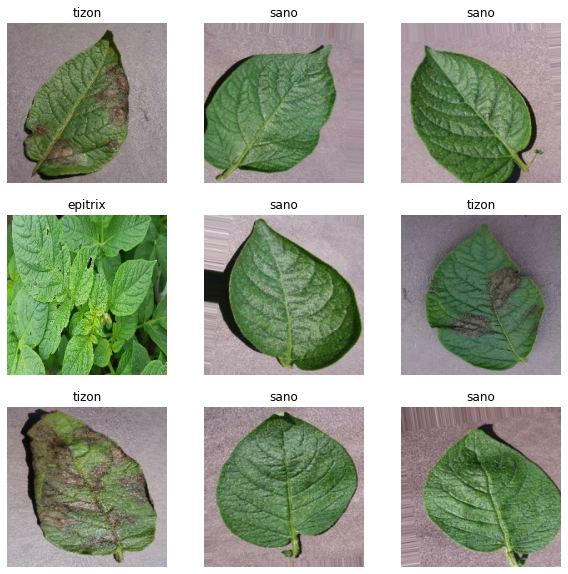

In [54]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax =plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [55]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch , labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image)," - ",np.max(first_image))

num_classes = 3

0.0  -  0.98349243


In [56]:
# model = Sequential([
#     layers.InputLayer(input_shape=(img_hei, img_wid, 3)),
#     #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_hei, img_wid, 3)),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(224, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='softmax'),
#     tf.keras.layers.Dropout(0.5),
#     layers.Dense(num_classes)
# ])
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))
mobilenetv2.trainable = False
model = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs=35

history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/35
5/5 [==============================] - 7s 1s/step - loss: 1.5274 - accuracy: 0.3371 - val_loss: 0.9860 - val_accuracy: 0.3817
Epoch 2/35
5/5 [==============================] - 5s 1s/step - loss: 0.9902 - accuracy: 0.4735 - val_loss: 0.9733 - val_accuracy: 0.5954
Epoch 3/35
5/5 [==============================] - 5s 921ms/step - loss: 0.9281 - accuracy: 0.5985 - val_loss: 0.8744 - val_accuracy: 0.5496
Epoch 4/35
5/5 [==============================] - 5s 922ms/step - loss: 0.8141 - accuracy: 0.6875 - val_loss: 0.7580 - val_accuracy: 0.6870
Epoch 5/35
5/5 [==============================] - 5s 1s/step - loss: 0.6939 - accuracy: 0.7462 - val_loss: 0.6631 - val_accuracy: 0.7328
Epoch 6/35
5/5 [==============================] - 5s 930ms/step - loss: 0.6031 - accuracy: 0.7765 - val_loss: 0.5855 - val_accuracy: 0.7710
Epoch 7/35
5/5 [==============================] - 5s 1s/step - loss: 0.5276 - accuracy: 0.7955 - val_loss: 0.5515 - val_accuracy: 0.8015
Epoch 8/35
5/5 [================

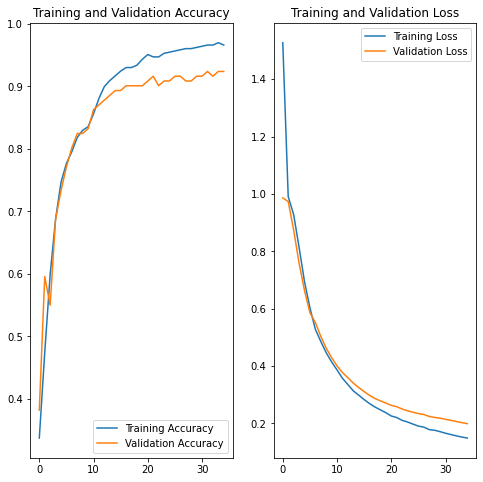

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
model.save('model_tesis')

INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


In [64]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_18 (Dense)            (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
